## Karpathy Neural Nets - Zero to Hero 
Basically rebuilding his micrograd project.

In [199]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Neural networks are very big mathematical expressions so we need values and expressions to model them

In [208]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, {self, other}, '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, {self, other}, '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    # One problem with this is if we reuse variables, then their gradients are stored and reused for
    # different equations
    # This is solved in the _backward() functions of __add__, __mul__, and tanh by accumulating the
    # gradients with += instead of just resetting them with = every time
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(o)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [209]:
a = Value(2.0)
a*2

Value(data=4.0)

In [201]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

The grad is just the derivative of the entire function (L) with respect to the current value (a, b, c, etc.). The gradient is just the slope of the function at the current position (derivative).

So if you wanted to get grad of a you would have to take the derivative of e with respect to a which is de/da and because it's a multiplication statment it is equal to b. (((a+h) * b) - (a*b)) / h = ((a*b + h*b) - a*b) / h = h*b / h = b.

In this case if we wanted to find the grad of L with respect to a we need recursive application of chain rule. This is how you find all of the gradients for the entire model. Example: dL/da = (de/da) * (dd/de) * (dL/dd)

Optimization is the adjustment of the weights.
Loss function gets the loss

In [202]:
# Neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

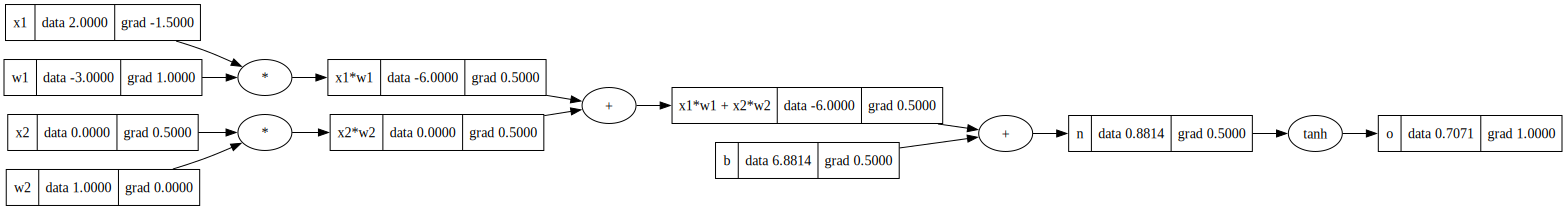

In [196]:
draw_dot(o)